In [1]:
import os
import sys
import json
import time
import ffmpeg
import itertools
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.nn.utils.spectral_norm as spectralnorm
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from PIL import Image
from pytorch_msssim import ssim
import lpips

from models import *
from utils import *
from helper import *

thirdparty_repo_path = os.path.abspath("/h/lkcai/code/video-perception/DCVC_HEM")
if thirdparty_repo_path not in sys.path:
    sys.path.insert(0, thirdparty_repo_path)
    
thirdparty_repo_path = os.path.abspath("/h/lkcai/code/video-perception/video_quality_metrics")
if thirdparty_repo_path not in sys.path:
    sys.path.insert(0, thirdparty_repo_path)

from DCVC_HEM.src.models.video_model import DMC
from DCVC_HEM.src.models.image_model import IntraNoAR
from DCVC_HEM.src.utils.stream_helper import get_state_dict

from video_quality_metrics.calculate_fvd import calculate_fvd


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
!nvidia-smi

/h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Wed Mar 26 14:43:20 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:86:00.0 Off |                    0 |
| N/A   38C    P8    16W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def load_ssf_model(model, pre_path):
    model.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
    model.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
    model.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
    model.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
    model.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))
    return model

In [3]:
def PSNR(input1, input2):
    mse = torch.mean((input1 - input2) ** 2)
    psnr = 20 * torch.log10(1 / torch.sqrt(mse))
    return psnr.item()

def MS_SSIM(v1, v2):
    return ssim(v1, v2, data_range=1, size_average=True).item()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.reshape(-1, 64 * 16 * 16)  # Flatten the output
        y = self.relu(self.fc1(x))
        x = self.fc2(y)
        return x, x

# second frame 
mnist_model_2 = Net().to(device)
mnist_model_2.load_state_dict(torch.load('./mnist_net.pth'))
mnist_model_2.eval()

def LPIPS_2(img1, img2):
    for param in mnist_model_2.parameters():
        param.requires_grad = False
    
    with torch.no_grad():
        pred1, feat1 = mnist_model_2(img1)
        pred2, feat2 = mnist_model_2(img2)
        
    feat1 = F.normalize(feat1)
    feat2 = F.normalize(feat2)
    
    return torch.mean((feat1 - feat2) ** 2).item()

# third frame
mnist_model_3 = Net().to(device)
mnist_model_3.load_state_dict(torch.load('./mnist_net_3.pth'))
mnist_model_3.eval()

def LPIPS_3(img1, img2):
    for param in mnist_model_3.parameters():
        param.requires_grad = False
    
    with torch.no_grad():
        pred1, feat1 = mnist_model_3(img1)
        pred2, feat2 = mnist_model_3(img2)
    
    feat1 = F.normalize(feat1)
    feat2 = F.normalize(feat2)
    
    return torch.mean((feat1 - feat2) ** 2).item()


In [4]:
def run_h264(frames, crf=100, preset="veryslow"):
    height, width = frames.shape[1], frames.shape[2]
    
    frames = (frames * 255).clamp(0, 255).squeeze().cpu().numpy()
    process = (
        ffmpeg
        .input('pipe:', format='rawvideo', pix_fmt='gray', s='{}x{}'.format(width, height))
        .output(
            'pipe:', vcodec='libx264', pix_fmt='gray', crf=crf, preset=preset, format='h264')        
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
    )

    for frame in frames:
        frame = frame.astype(np.uint8)
        process.stdin.write(frame.tobytes())
    
    process.stdin.close()
    compressed_output = process.stdout.read()
    compressed_videos = np.frombuffer(compressed_output, dtype=np.uint8)
    
    frame_sizes = []
    i = 0
    while i < len(compressed_videos):
        if i + 4 < len(compressed_videos) and compressed_videos[i:i + 4].tolist() == [0, 0, 0, 1]:
            start = i
            i += 4
            while i + 4 < len(compressed_videos) and compressed_videos[i:i + 4].tolist() != [0, 0, 0, 1]:
                i += 1
            end = i
            frame_sizes.append(end - start)
        else:
            i += 1

    bits = [size * 8 for size in frame_sizes][1:]
    for idx, bitrate in enumerate(bits):
        print(f"H.264: Frame {idx + 1}: {bitrate} bits")

    process_decode = (
        ffmpeg
        .input('pipe:', format='h264')
        .output('pipe:', format='rawvideo', pix_fmt='gray', s='{}x{}'.format(width, height))
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
    )

    process_decode.stdin.write(compressed_output)
    process_decode.stdin.close()

    decomp_output = process_decode.stdout.read()

    num_frames = len(decomp_output) // (height * width)
    recon_frames = np.frombuffer(decomp_output, dtype=np.uint8).reshape(num_frames, height, width)
    
    recon_frames = torch.from_numpy(recon_frames).float().to(device)
    recon_frames = recon_frames / 255.
    
    x0_hat = recon_frames[0, :, :].unsqueeze(0)
    x1_hat = recon_frames[1, :, :].unsqueeze(0)
    x2_hat = recon_frames[2, :, :].unsqueeze(0)
    
    return x0_hat, x1_hat, x2_hat

In [5]:
model_path = './DCVC_HEM/checkpoints/dcvc-hem_v_bit-lamb-1.0_scale-1.2_ft_epoch_5.pth'
    
p_frame_y_q_scales, p_frame_mv_y_q_scales = DMC.get_q_scales_from_ckpt(model_path)

p_state_dict = get_state_dict(model_path)
video_net = DMC()
video_net.load_state_dict(p_state_dict)
video_net = video_net.to(device)
video_net.eval()

def run_dcvc_test(x1_hat, x2):
    x1_hat = x1_hat.repeat(1, 3, 1, 1)
    x2 = x2.repeat(1, 3, 1, 1)

    rate_idx = 0

    p_frame_y_q_scale = torch.tensor(1.35) # p_frame_y_q_scales[rate_idx]
    p_frame_mv_y_q_scale = torch.tensor(1.35) # p_frame_y_q_scales[rate_idx]

    with torch.no_grad():
        pic_height = x2.shape[2]
        pic_width = x2.shape[3]

        bin_path = None

        dpb = {
            "ref_frame": x1_hat,
            "ref_feature": None,
            "ref_y": None,
            "ref_mv_y": None,
        }

        x2_result = video_net.encode_decode(
            x2, dpb, bin_path,
            pic_height=pic_height, pic_width=pic_width,
            mv_y_q_scale=p_frame_mv_y_q_scale,
            y_q_scale=p_frame_y_q_scale
        )
        dpb = x2_result["dpb"]
        x2_hat = dpb["ref_frame"]
        x2_hat = x2_hat.clamp_(0, 1)
    
    # print("DCVC bitrates: ", x2_result['bit'] / 64)

    return x2_hat.mean(dim=1, keepdim=True)

In [7]:
def plot_inf_eps1_eps2(
    x0, x1, x2, 
    x1_JD, x1_AR, x1_FMD, x1_MSE,
    x2_JD, x2_AR, x2_FMD, x2_MSE,
    x1_DCVC, x2_DCVC, 
    eps1, eps2, step
):
    fig, axarr = plt.subplots(
        6, 5, dpi=250, 
        gridspec_kw={
            'wspace': 0.0, 'hspace': 0.01, 'width_ratios': [0.2, 1, 1, 1, 1]}
    )
    fig.set_size_inches(6.95, 10.27)
    plt.rcParams.update({
        'font.family': 'FreeSerif',
        'mathtext.fontset': 'custom',
        'mathtext.rm': 'FreeSerif',
        'mathtext.it': 'FreeSerif:italic',
        'mathtext.bf': 'FreeSerif:bold',
    })
    
    for i in range(6):
        for j in range(5):
            axarr[i,j].axis('off')
            
    fontsize = 16
    
    axarr[0, 1].set_title(r"$X_1$", fontsize=fontsize)
    axarr[0, 2].set_title(r"$X_2$", fontsize=fontsize)
    axarr[0, 3].set_title(r"$X_3$", fontsize=fontsize)
    axarr[0, 4].set_title(r"Trajectory", fontsize=fontsize)
    
    axarr[0, 0].text(0.5, 0.5, r"Source", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[0, 0].transAxes, fontsize=fontsize)
    axarr[1, 0].text(0.5, 0.5, r"DCVC-HEM", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[1, 0].transAxes, fontsize=fontsize)
    axarr[2, 0].text(0.5, 0.5, r"MMSE", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[2, 0].transAxes, fontsize=fontsize)
    axarr[3, 0].text(0.5, 0.5, r"0-PLF-JD", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[3, 0].transAxes, fontsize=fontsize)
    axarr[4, 0].text(0.5, 0.5, r"0-PLF-FMD", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[4, 0].transAxes, fontsize=fontsize)
    axarr[5, 0].text(0.5, 0.5, r"0-PLF-SA", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[5, 0].transAxes, fontsize=fontsize)
    
    zeros = torch.zeros_like(x0)
    x0_img = torch.cat((x0, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x1_img = torch.cat((zeros, x1, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_img = torch.cat((zeros, zeros, x2), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    or_t = torch.cat((x0, x1, x2), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x1_MSE_img = torch.cat((zeros, x1_MSE, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_MSE_img = torch.cat((zeros, zeros, x2_MSE), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    mse_t = torch.cat((x0, x1_MSE, x2_MSE), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x1_JD_img = torch.cat((zeros, x1_JD, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_JD_img = torch.cat((zeros, zeros, x2_JD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    jd_t = torch.cat((x0, x1_JD, x2_JD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x1_AR_img = torch.cat((zeros, x1_AR, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_AR_img = torch.cat((zeros, zeros, x2_AR), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    ar_t = torch.cat((x0, x1_AR, x2_AR), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x1_FMD_img = torch.cat((zeros, x1_FMD, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_FMD_img = torch.cat((zeros, zeros, x2_FMD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    fmd_t = torch.cat((x0, x1_FMD, x2_FMD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x1_dcvc_img = torch.cat((zeros, x1_DCVC, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_dcvc_img = torch.cat((zeros, zeros, x2_DCVC), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    dcvc_t = torch.cat((x0, x1_DCVC, x2_DCVC), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    # x0_h264_img = torch.cat((x0_h264, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    # x1_h264_img = torch.cat((zeros, x1_h264, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    # x2_h264_img = torch.cat((zeros, zeros, x2_h264), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    # h264_t = torch.cat((x0_h264, x1_h264, x2_h264), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()

    axarr[0, 1].imshow(x0_img)
    axarr[0, 2].imshow(x1_img)
    axarr[0, 3].imshow(x2_img)
    axarr[0, 4].imshow(or_t)
    
    axarr[1, 1].imshow(x0_img)
    axarr[1, 2].imshow(x1_dcvc_img)
    axarr[1, 3].imshow(x2_dcvc_img)
    axarr[1, 4].imshow(dcvc_t)
    
    axarr[2, 1].imshow(x0_img)
    axarr[2, 2].imshow(x1_MSE_img)
    axarr[2, 3].imshow(x2_MSE_img)
    axarr[2, 4].imshow(mse_t)
    
    axarr[3, 1].imshow(x0_img)
    axarr[3, 2].imshow(x1_JD_img)
    axarr[3, 3].imshow(x2_JD_img)
    axarr[3, 4].imshow(jd_t)
    
    axarr[4, 1].imshow(x0_img)
    axarr[4, 2].imshow(x1_FMD_img)
    axarr[4, 3].imshow(x2_FMD_img)
    axarr[4, 4].imshow(fmd_t)
    
    axarr[5, 1].imshow(x0_img)
    axarr[5, 2].imshow(x1_AR_img)
    axarr[5, 3].imshow(x2_AR_img)
    axarr[5, 4].imshow(ar_t)
    
    save_path = f'./reconstructions/inf-eps1-eps2/inf-{eps1}-{eps2}/step{step}/'
    os.makedirs(save_path, exist_ok=True)
                      
    plt.imsave(save_path + "x0.png", x0_img)
    plt.imsave(save_path + "x1.png", x1_img)
    plt.imsave(save_path + "x2.png", x2_img)
    plt.imsave(save_path + "traj.png", or_t)
    
    plt.imsave(save_path + "x1_JD.png", x1_JD_img)
    plt.imsave(save_path + "x2_JD.png", x2_JD_img)
    plt.imsave(save_path + "traj_JD.png", jd_t)
    
    plt.imsave(save_path + "x1_AR.png", x1_AR_img)
    plt.imsave(save_path + "x2_AR.png", x2_AR_img)
    plt.imsave(save_path + "traj_AR.png", ar_t)
    
    plt.imsave(save_path + "x1_FMD.png", x1_FMD_img)
    plt.imsave(save_path + "x2_FMD.png", x2_FMD_img)
    plt.imsave(save_path + "traj_FMD.png", fmd_t)
    
    plt.imsave(save_path + "x1_DCVC.png", x1_dcvc_img)
    plt.imsave(save_path + "x2_DCVC.png", x2_dcvc_img)
    plt.imsave(save_path + "traj_DCVC.png", dcvc_t)
    
    # plt.imsave(save_path + "x0_H264.png", x0_h264_img)
    # plt.imsave(save_path + "x1_H264.png", x1_h264_img)
    # plt.imsave(save_path + "x2_H264.png", x2_h264_img)
    # plt.imsave(save_path + "traj_H264.png", h264_t)

In [8]:
def inf_eps1_eps2(
    l_JD1=0.0, l_FMD1=0.0,
    l_JD2=0.0, l_FMD2=0.0, l_AR2=0.0,
    eps1=2, eps2=8, x=0, 
    step=20, stochastic=True, save=False, dataset='dataset'
):
    pre_path_JD1  = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_{l_JD1}|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_FMD1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_0.0|' + \
                    f'lambdaFMD_{l_FMD1}|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_MSE1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_0.0|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    
    pre_path_FMD1_dcvc = f'./saved_models/inf-eps/step_20/inf-2|lambdaJD_0.0|' + \
                     f'lambdaFMD_0.06|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    
    pre_path_JD2  = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_{l_JD2}|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_FMD2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|' + \
                    f'lambdaFMD_{l_FMD2}|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_NEW2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|' + \
                    f'lambdaFMD_0.0|lambdaNEW_{l_AR2}|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_MSE2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|pretrained_JD_0.01|dataset_{dataset}'

    zdim_1 = eps1 // 2
    zdim_2 = eps2 // 2

    #load models for second frame
    ssf_JD1 = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2
    ).to(device).eval()
    ssf_FMD1 = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
    ).to(device).eval()
    ssf_MSE1 = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2
    ).to(device).eval()
    
    ssf_FMD1_dcvc = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
    ).to(device).eval()
    
    ssf_JD1  = load_ssf_model(ssf_JD1, pre_path_JD1)
    ssf_FMD1 = load_ssf_model(ssf_FMD1, pre_path_FMD1)
    ssf_MSE1 = load_ssf_model(ssf_MSE1, pre_path_MSE1)
    
    ssf_FMD1_dcvc = load_ssf_model(ssf_FMD1_dcvc, pre_path_FMD1_dcvc)

    #load models for third frame 
    ssf_JD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)
    ssf_NEW2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)
    ssf_FMD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)
    ssf_MSE2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)

    ssf_JD2  = load_ssf_model(ssf_JD2, pre_path_JD2)
    ssf_NEW2 = load_ssf_model(ssf_NEW2, pre_path_NEW2)
    ssf_FMD2 = load_ssf_model(ssf_FMD2, pre_path_FMD2)
    ssf_MSE2 = load_ssf_model(ssf_MSE2, pre_path_MSE2)
    
    # original frames
#     x0 = Image.open(x0_path)
#     x1 = Image.open(x1_path)
#     x2 = Image.open(x2_path)
    
#     transform = transforms.Compose([
#         transforms.Resize(64),
#         transforms.ToTensor()
#     ])
    
#     x0 = transform(x0)[0].unsqueeze(0).unsqueeze(0).cuda()
#     x1 = transform(x1)[1].unsqueeze(0).unsqueeze(0).cuda()
#     x2 = transform(x2)[2].unsqueeze(0).unsqueeze(0).cuda()
#     print(x0.min(), x0.max(), x0.shape)
#     print(x1.min(), x1.max(), x1.shape)
#     print(x2.min(), x2.max(), x2.shape)

    mse_eval = {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
    jd_eval =  {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
    fmd_eval = {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
    ar_eval =  {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
    dcvc_eval = {'3_psnr': [], '3_perc': []}
    
    # original frames
    x0 = x[:, :, 0, ...]
    x1 = x[:, :, 1, ...]
    x2 = x[:, :, 2, ...]

    with torch.no_grad():
        # second frames
        x1_hat_JD  = ssf_JD1(x1, x0)
        # x1_hat_NEW = ssf_JD1(x1, x0)
        x1_hat_FMD = ssf_FMD1(x1, x0)
        x1_hat_MSE = ssf_MSE1(x1, x0)

        # third frames
        x2_hat_JD  = ssf_JD2(x2, x1_hat_JD, x0, x1_hat_JD)
        x2_hat_FMD = ssf_FMD2(x2, x1_hat_FMD, x0, x1_hat_FMD)
        x2_hat_NEW = ssf_NEW2(x2, x1_hat_JD, x0, x1_hat_JD)
        x2_hat_MSE = ssf_MSE2(x2, x1_hat_MSE, x0, x1_hat_MSE)

        x1_hat_dcvc = ssf_FMD1_dcvc(x1, x0)
        x2_hat_dcvc = run_dcvc_test(x1_hat_dcvc, x2)
        
#         jd_eval['2_perc'].append(LPIPS_2(x1, x1_hat_JD))
#         fmd_eval['2_perc'].append(LPIPS_2(x1, x1_hat_FMD))
#         ar_eval['2_perc'].append(LPIPS_2(x1, x1_hat_JD))
        
#         print('jd', jd_eval['2_perc'])
#         print('fmd', fmd_eval['2_perc'])
#         print('ar', ar_eval['2_perc'])


        plot_inf_eps1_eps2(
            x0[0], x1[0], x2[0],
            x1_hat_JD[0], x1_hat_JD[0], x1_hat_FMD[0], x1_hat_MSE[0],
            x2_hat_JD[0], x2_hat_NEW[0], x2_hat_FMD[0], x2_hat_MSE[0],
            x1_hat_dcvc[0], x2_hat_dcvc[0], 
            eps1, eps2, step
        )


Finished Loading MovingMNIST_4_axis_random_sample_step!
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]


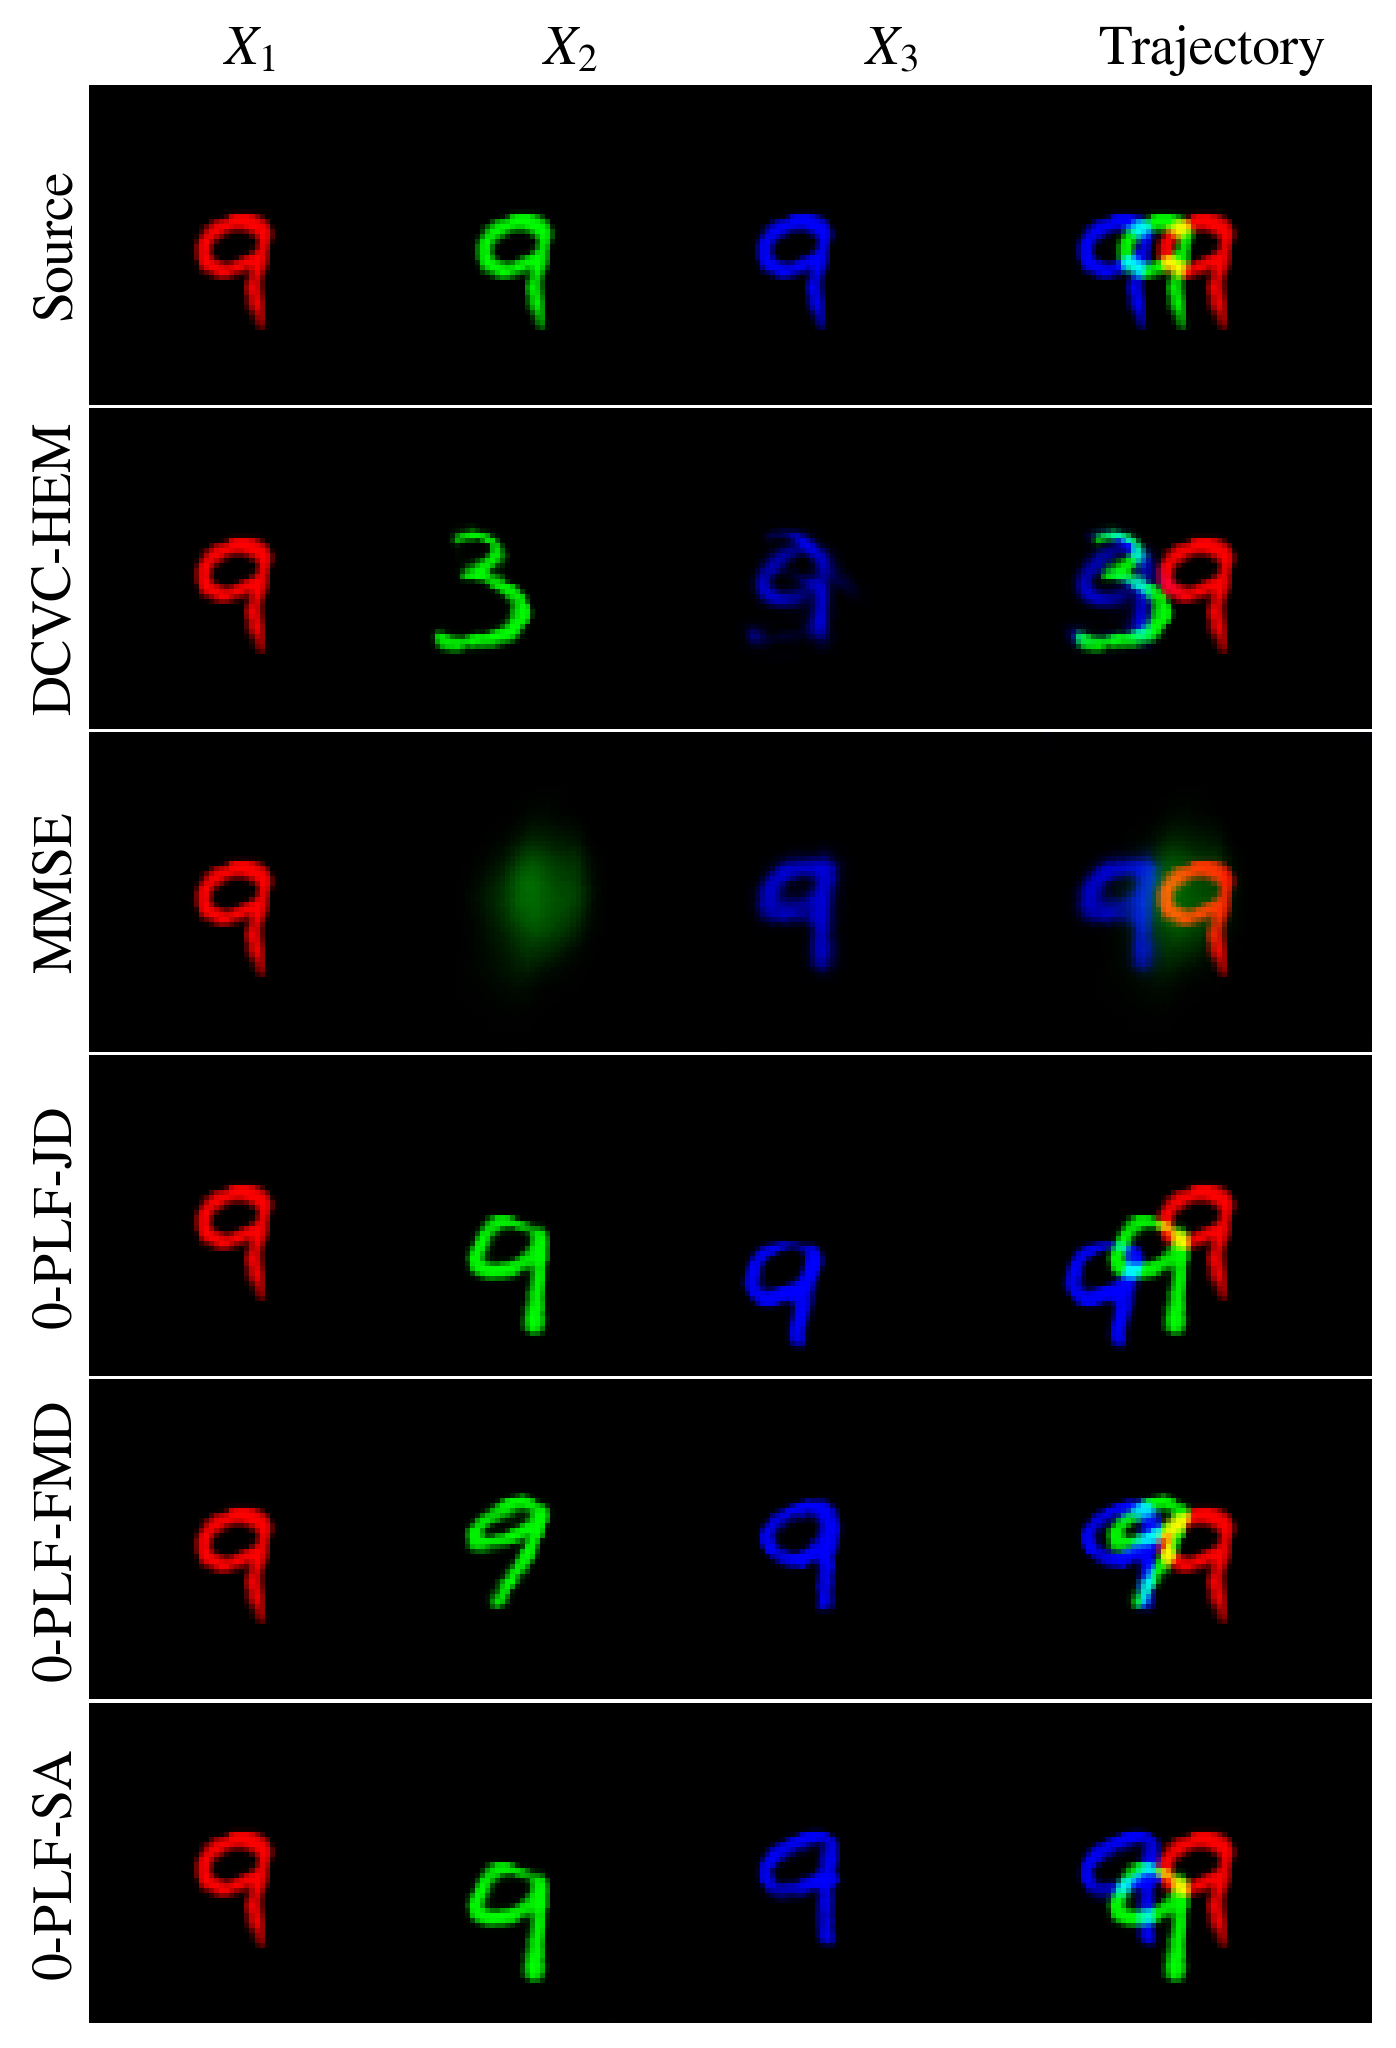

In [223]:
step = 20
dataset = 'mmnist_4_axis_random_sample_step'
loader, _ = get_dataloader(
    data_root='./data/', 
    dataset=dataset, 
    step=step, 
    seq_len=3, 
    batch_size=64, 
    num_digits=1
)
x = next(iter(loader))[0].permute(0, 4, 1, 2, 3).to(device).float()

inf_eps1_eps2(
    l_JD1=0.2, l_FMD1=0.03, 
    l_JD2=0.2, l_FMD2=0.03, l_AR2=0.2, 
    eps1=2, eps2=16, x=x, 
    step=step, dataset=dataset
)

In [7]:
def inf_eps1_eps2(
    l_JD1=0.0, l_FMD1=0.0,
    l_JD2=0.0, l_FMD2=0.0, l_AR2=0.0,
    eps1=2, eps2=8, x=0, 
    step=20, stochastic=True, save=False, dataset='dataset'
):
    pre_path_JD1  = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_{l_JD1}|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_FMD1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_0.0|' + \
                    f'lambdaFMD_{l_FMD1}|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_MSE1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_0.0|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    
    pre_path_JD2  = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_{l_JD2}|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_FMD2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|' + \
                    f'lambdaFMD_{l_FMD2}|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_NEW2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|' + \
                    f'lambdaFMD_0.0|lambdaNEW_{l_AR2}|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_MSE2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|pretrained_JD_0.01|dataset_{dataset}'

    zdim_1 = eps1 // 2
    zdim_2 = eps2 // 2

    #load models for second frame
    ssf_JD1 = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2
    ).to(device).eval()
    ssf_FMD1 = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
    ).to(device).eval()
    ssf_MSE1 = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2
    ).to(device).eval()
    
    ssf_JD1  = load_ssf_model(ssf_JD1, pre_path_JD1)
    ssf_FMD1 = load_ssf_model(ssf_FMD1, pre_path_FMD1)
    ssf_MSE1 = load_ssf_model(ssf_MSE1, pre_path_MSE1)

    #load models for third frame 
    ssf_JD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)
    ssf_NEW2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)
    ssf_FMD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)
    ssf_MSE2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)

    ssf_JD2  = load_ssf_model(ssf_JD2, pre_path_JD2)
    ssf_NEW2 = load_ssf_model(ssf_NEW2, pre_path_NEW2)
    ssf_FMD2 = load_ssf_model(ssf_FMD2, pre_path_FMD2)
    ssf_MSE2 = load_ssf_model(ssf_MSE2, pre_path_MSE2)
    
    # original frames
#     x0_path = "./reconstructions/inf-eps1-eps2/inf-2-16/step20_joao/x0.png"
#     x1_path = "./reconstructions/inf-eps1-eps2/inf-2-16/step20_joao/x1.png"
#     x2_path = "./reconstructions/inf-eps1-eps2/inf-2-16/step20_joao/x2.png"
    
#     x0 = Image.open(x0_path)
#     x1 = Image.open(x1_path)
#     x2 = Image.open(x2_path)
    
#     transform = transforms.Compose([
#         transforms.Resize(64),
#         transforms.ToTensor()
#     ])
    
#     x0 = transform(x0)[0].unsqueeze(0).unsqueeze(0).cuda()
#     x1 = transform(x1)[1].unsqueeze(0).unsqueeze(0).cuda()
#     x2 = transform(x2)[2].unsqueeze(0).unsqueeze(0).cuda()
#     print(x0.min(), x0.max(), x0.shape)
#     print(x1.min(), x1.max(), x1.shape)
#     print(x2.min(), x2.max(), x2.shape)
    
    # original frames
    
    step = 20
    dataset = 'mmnist_4_axis_random_sample_step'
    loader, _ = get_dataloader(
        data_root='./data/', 
        dataset=dataset, 
        step=step, 
        seq_len=3, 
        batch_size=1, 
        num_digits=1
    )

    mse_eval = {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
    jd_eval =  {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
    fmd_eval = {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
    ar_eval =  {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
    dcvc_eval = {'3_psnr': [], '3_perc': []}
    i = 0
    with torch.no_grad():
        for x in tqdm(loader):
            if i > 50:
                break
            x = x[0].permute(0, 4, 1, 2, 3).to(device).float()

            x0 = x[:, :, 0, ...]
            x1 = x[:, :, 1, ...]
            x2 = x[:, :, 2, ...]

            # second frames
            x1_hat_JD  = ssf_JD1(x1, x0)
            # x1_hat_NEW = ssf_JD1(x1, x0)
            x1_hat_FMD = ssf_FMD1(x1, x0)
            x1_hat_MSE = ssf_MSE1(x1, x0)

            # third frames
            x2_hat_JD  = ssf_JD2(x2, x1_hat_JD, x0, x1_hat_JD)
            x2_hat_FMD = ssf_FMD2(x2, x1_hat_FMD, x0, x1_hat_FMD)
            x2_hat_NEW = ssf_NEW2(x2, x1_hat_JD, x0, x1_hat_JD)
            x2_hat_MSE = ssf_MSE2(x2, x1_hat_MSE, x0, x1_hat_MSE)

            x2_hat_DCVC = run_dcvc_test(x1_hat_JD, x2)

            jd_eval['2_perc'].append(LPIPS_2(x1, x1_hat_JD))
            fmd_eval['2_perc'].append(LPIPS_2(x1, x1_hat_FMD))
            ar_eval['2_perc'].append(LPIPS_2(x1, x1_hat_JD))
            
            jd_eval['3_perc'].append(LPIPS_3(x2, x2_hat_JD))
            fmd_eval['3_perc'].append(LPIPS_3(x2, x2_hat_FMD))
            ar_eval['3_perc'].append(LPIPS_3(x2, x2_hat_NEW))
            dcvc_eval['3_perc'].append(LPIPS_3(x2, x2_hat_DCVC))
            
            i += 1
    
    jd_perc = sum(jd_eval['2_perc']) / i
    fmd_perc = sum(fmd_eval['2_perc']) / i
    ar_perc = sum(ar_eval['2_perc']) / i
    print(jd_perc, fmd_perc, ar_perc)
    
#     jd_perc_3 = sum(jd_eval['3_perc']) / i
#     fmd_perc_3 = sum(fmd_eval['3_perc']) / i
#     ar_perc_3 = sum(ar_eval['3_perc']) / i
#     dcvc_perc_3 = sum(dcvc_eval['3_perc']) / i
#     print(jd_perc_3, fmd_perc_3, ar_perc_3, dcvc_perc_3)

#         plot_inf_eps1_eps2(
#             x0[0], x1[0], x2[0],
#             x1_hat_JD[0], x1_hat_JD[0], x1_hat_FMD[0], x1_hat_MSE[0],
#             x2_hat_JD[0], x2_hat_NEW[0], x2_hat_FMD[0], x2_hat_MSE[0],
#             x2_hat_DCVC[0], 
#             eps1, eps2, step
#         )


In [8]:
step = 20
dataset = 'mmnist_4_axis_random_sample_step'
# loader, _ = get_dataloader(
#     data_root='./data/', 
#     dataset=dataset, 
#     step=step, 
#     seq_len=3,
#     batch_size=1,
#     num_digits=1
# )
# x = next(iter(loader))[0].permute(0, 4, 1, 2, 3).to(device).float()

inf_eps1_eps2(
    l_JD1=0.2, l_FMD1=0.03, 
    l_JD2=0.2, l_FMD2=0.03, l_AR2=0.2, 
    eps1=2, eps2=16, x=None, 
    step=step, dataset=dataset
)

[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]


/h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finished Loading MovingMNIST_4_axis_random_sample_step!


  0%|          | 51/60000 [00:08<2:49:29,  5.89it/s]

3.6518755403219485 3.8231858482547834 3.6518755403219485


In [64]:
step = 20
dataset = 'mmnist_4_axis_random_sample_step'
loader, _ = get_dataloader(
    data_root='./data/', 
    dataset=dataset, 
    step=step, 
    seq_len=3,
    batch_size=64, 
    num_digits=1
)

pre_path_JD1  = f'./saved_models/inf-eps/step_20/inf-2|lambdaJD_0.2|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_FMD1 = f'./saved_models/inf-eps/step_20/inf-2|lambdaJD_0.0|' + \
                f'lambdaFMD_0.03|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_MSE1 = f'./saved_models/inf-eps/step_20/inf-2|lambdaJD_0.0|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'

pre_path_FMD1_dcvc = f'./saved_models/inf-eps/step_20/inf-2|lambdaJD_0.0|' + \
                     f'lambdaFMD_0.06|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'

pre_path_JD2  = f'./saved_models/inf-eps1-eps2/step_20/inf-2-16|lambdaJD_0.2|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_FMD2 = f'./saved_models/inf-eps1-eps2/step_20/inf-2-16|lambdaJD_0.0|' + \
                f'lambdaFMD_0.03|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_NEW2 = f'./saved_models/inf-eps1-eps2/step_20/inf-2-16|lambdaJD_0.0|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.2|lambdaMSE_1.0|dataset_{dataset}'
pre_path_MSE2 = f'./saved_models/inf-eps1-eps2/step_20/inf-2-16|lambdaJD_0.0|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|pretrained_JD_0.01|dataset_{dataset}'

zdim_1 = 2 // 2
zdim_2 = 16 // 2

#load models for second frame
ssf_JD1 = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2
).to(device).eval()
ssf_FMD1 = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
).to(device).eval()
ssf_MSE1 = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
).to(device).eval()

ssf_FMD1_dcvc = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
).to(device).eval()

ssf_JD1  = load_ssf_model(ssf_JD1, pre_path_JD1)
ssf_FMD1 = load_ssf_model(ssf_FMD1, pre_path_FMD1)
ssf_MSE1 = load_ssf_model(ssf_MSE1, pre_path_MSE1)

ssf_FMD1_dcvc = load_ssf_model(ssf_FMD1_dcvc, pre_path_FMD1_dcvc)

#load models for third frame 
ssf_JD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)
ssf_NEW2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)
ssf_FMD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)
ssf_MSE2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)

ssf_JD2  = load_ssf_model(ssf_JD2, pre_path_JD2)
ssf_NEW2 = load_ssf_model(ssf_NEW2, pre_path_NEW2)
ssf_FMD2 = load_ssf_model(ssf_FMD2, pre_path_FMD2)
ssf_MSE2 = load_ssf_model(ssf_MSE2, pre_path_MSE2)

mse_eval = {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
jd_eval =  {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
fmd_eval = {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
ar_eval =  {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}
dcvc_eval = {'2_psnr':[], '3_psnr': [], '2_perc': [], '3_perc': []}

with torch.no_grad():
    for x in tqdm(loader):
        x = x[0].permute(0, 4, 1, 2, 3).to(device).float()

        # original frames
        x0 = x[:, :, 0, ...]
        x1 = x[:, :, 1, ...]
        x2 = x[:, :, 2, ...]

        # second frames
        x1_hat_JD  = ssf_JD1(x1, x0)
        x1_hat_AR = ssf_JD1(x1, x0)
        x1_hat_FMD = ssf_FMD1(x1, x0)
        x1_hat_MSE = ssf_MSE1(x1, x0)
        
        x1_hat_dcvc = ssf_FMD1_dcvc(x1, x0)

        # third frames
        x2_hat_JD  = ssf_JD2(x2, x1_hat_JD, x0, x1_hat_JD)
        x2_hat_AR = ssf_NEW2(x2, x1_hat_AR, x0, x1_hat_AR)
        x2_hat_FMD = ssf_FMD2(x2, x1_hat_FMD, x0, x1_hat_FMD)
        x2_hat_MSE = ssf_MSE2(x2, x1_hat_MSE, x0, x1_hat_MSE)

        x2_hat_dcvc = run_dcvc_test(x1_hat_dcvc, x2)

        mse_eval['2_psnr'].append(PSNR(x1, x1_hat_MSE))
        mse_eval['3_psnr'].append(PSNR(x2, x2_hat_MSE))
        mse_eval['2_perc'].append(LPIPS_2(x1, x1_hat_MSE))
        mse_eval['3_perc'].append(LPIPS_3(x2, x2_hat_MSE))

        jd_eval['2_psnr'].append(PSNR(x1, x1_hat_JD))
        jd_eval['3_psnr'].append(PSNR(x2, x2_hat_JD))
        jd_eval['2_perc'].append(LPIPS_2(x1, x1_hat_JD))
        jd_eval['3_perc'].append(LPIPS_3(x2, x2_hat_JD))

        fmd_eval['2_psnr'].append(PSNR(x1, x1_hat_FMD))
        fmd_eval['3_psnr'].append(PSNR(x2, x2_hat_FMD))
        fmd_eval['2_perc'].append(LPIPS_2(x1, x1_hat_FMD))
        fmd_eval['3_perc'].append(LPIPS_3(x2, x2_hat_FMD))

        ar_eval['2_psnr'].append(PSNR(x1, x1_hat_AR))
        ar_eval['3_psnr'].append(PSNR(x2, x2_hat_AR))
        ar_eval['2_perc'].append(LPIPS_2(x1, x1_hat_AR))
        ar_eval['3_perc'].append(LPIPS_3(x2, x2_hat_AR))
        
        dcvc_eval['2_psnr'].append(PSNR(x1, x1_hat_dcvc))
        dcvc_eval['2_perc'].append(LPIPS_2(x1, x1_hat_dcvc))
        dcvc_eval['3_psnr'].append(PSNR(x2, x2_hat_dcvc))
        dcvc_eval['3_perc'].append(LPIPS_3(x2, x2_hat_dcvc))

def compute_stats(eval_dict):
    stats = {}
    for key, values in eval_dict.items():
        values = np.array(values)
        mean_val = np.mean(values)
        std_val = np.std(values)
        stats[key] = (mean_val, std_val)
    return stats

mse_stats = compute_stats(mse_eval)
jd_stats = compute_stats(jd_eval)
fmd_stats = compute_stats(fmd_eval)
ar_stats = compute_stats(ar_eval)
dcvc_stats = compute_stats(dcvc_eval)

print('Second frame PSNR:    ' + 
      f'MSE {mse_stats["2_psnr"][0]:.4f}±{mse_stats["2_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["2_psnr"][0]:.6f}±{jd_stats["2_psnr"][1]:.6f} | ' +
      f'FMD {fmd_stats["2_psnr"][0]:.6f}±{fmd_stats["2_psnr"][1]:.6f} | ' +
      f'AR {ar_stats["2_psnr"][0]:.6f}±{ar_stats["2_psnr"][1]:.6f} | ' +
      f'DCVC {dcvc_stats["2_psnr"][0]:.6f}±{dcvc_stats["2_psnr"][1]:.6f}')

print('Second frame PERC:    ' + 
      f'MSE {mse_stats["2_perc"][0]:.4f}±{mse_stats["2_perc"][1]:.4f} | ' +
      f'JD {jd_stats["2_perc"][0]:.6f}±{jd_stats["2_perc"][1]:.6f} | ' +
      f'FMD {fmd_stats["2_perc"][0]:.6f}±{fmd_stats["2_perc"][1]:.6f} | ' +
      f'AR {ar_stats["2_perc"][0]:.6f}±{ar_stats["2_perc"][1]:.6f} | ' +
      f'DCVC {dcvc_stats["2_perc"][0]:.6f}±{dcvc_stats["2_perc"][1]:.6f}')

print('Third frame PSNR:     ' + 
      f'MSE {mse_stats["3_psnr"][0]:.4f}±{mse_stats["3_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["3_psnr"][0]:.6f}±{jd_stats["3_psnr"][1]:.6f} | ' +
      f'FMD {fmd_stats["3_psnr"][0]:.6f}±{fmd_stats["3_psnr"][1]:.6f} | ' +
      f'AR {ar_stats["3_psnr"][0]:.6f}±{ar_stats["3_psnr"][1]:.6f} | ' +
      f'DCVC {dcvc_stats["3_psnr"][0]:.6f}±{dcvc_stats["3_psnr"][1]:.6f}')

print('Third frame PERC:     ' + 
      f'MSE {mse_stats["3_perc"][0]:.4f}±{mse_stats["3_perc"][1]:.4f} | ' +
      f'JD {jd_stats["3_perc"][0]:.6f}±{jd_stats["3_perc"][1]:.6f} | ' +
      f'FMD {fmd_stats["3_perc"][0]:.6f}±{fmd_stats["3_perc"][1]:.6f} | ' +
      f'AR {ar_stats["3_perc"][0]:.6f}±{ar_stats["3_perc"][1]:.6f} | ' +
      f'DCVC {dcvc_stats["3_perc"][0]:.6f}±{dcvc_stats["3_perc"][1]:.6f}')

Finished Loading MovingMNIST_4_axis_random_sample_step!
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]


100%|██████████| 937/937 [10:38<00:00,  1.47it/s]

Second frame PSNR:    MSE 17.6478±0.2399 | JD 13.541490±0.215374 | FMD 14.737771±0.230045 | AR 13.541490±0.215374 | DCVC 14.502189±0.225122
Second frame PERC:    MSE 0.1394±0.0085 | JD 0.026125±0.003732 | FMD 0.114084±0.007991 | AR 0.026125±0.003732 | DCVC 0.114295±0.008112
Third frame PSNR:     MSE 22.7717±0.4304 | JD 14.808558±0.263629 | FMD 20.713251±0.433001 | AR 20.465507±0.429625 | DCVC 21.428647±0.278775
Third frame PERC:     MSE 0.0531±0.0078 | JD 0.076159±0.008001 | FMD 0.024159±0.005315 | AR 0.021183±0.004950 | DCVC 0.072513±0.007675


In [60]:
print('Second frame PSNR:    ' + 
      f'MSE {mse_stats["2_psnr"][0]:.4f}±{mse_stats["2_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["2_psnr"][0]:.6f}±{jd_stats["2_psnr"][1]:.6f} | ' +
      f'FMD {fmd_stats["2_psnr"][0]:.6f}±{fmd_stats["2_psnr"][1]:.6f} | ' +
      f'AR {ar_stats["2_psnr"][0]:.6f}±{ar_stats["2_psnr"][1]:.6f} | ' +
      f'DCVC {dcvc_stats["2_psnr"][0]:.6f}±{dcvc_stats["2_psnr"][1]:.6f}')

print('Second frame PERC:    ' + 
      f'MSE {mse_stats["2_perc"][0]:.4f}±{mse_stats["2_perc"][1]:.4f} | ' +
      f'JD {jd_stats["2_perc"][0]:.6f}±{jd_stats["2_perc"][1]:.6f} | ' +
      f'FMD {fmd_stats["2_perc"][0]:.6f}±{fmd_stats["2_perc"][1]:.6f} | ' +
      f'AR {ar_stats["2_perc"][0]:.6f}±{ar_stats["2_perc"][1]:.6f} | ' +
      f'DCVC {dcvc_stats["2_perc"][0]:.6f}±{dcvc_stats["2_perc"][1]:.6f}')

print('Third frame PSNR:     ' + 
      f'MSE {mse_stats["3_psnr"][0]:.4f}±{mse_stats["3_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["3_psnr"][0]:.6f}±{jd_stats["3_psnr"][1]:.6f} | ' +
      f'FMD {fmd_stats["3_psnr"][0]:.6f}±{fmd_stats["3_psnr"][1]:.6f} | ' +
      f'AR {ar_stats["3_psnr"][0]:.6f}±{ar_stats["3_psnr"][1]:.6f} | ' +
      f'DCVC {dcvc_stats["3_psnr"][0]:.6f}±{dcvc_stats["3_psnr"][1]:.6f}')

print('Third frame PERC:     ' + 
      f'MSE {mse_stats["3_perc"][0]:.4f}±{mse_stats["3_perc"][1]:.4f} | ' +
      f'JD {jd_stats["3_perc"][0]:.6f}±{jd_stats["3_perc"][1]:.6f} | ' +
      f'FMD {fmd_stats["3_perc"][0]:.6f}±{fmd_stats["3_perc"][1]:.6f} | ' +
      f'AR {ar_stats["3_perc"][0]:.6f}±{ar_stats["3_perc"][1]:.6f} | ' +
      f'DCVC {dcvc_stats["3_perc"][0]:.6f}±{dcvc_stats["3_perc"][1]:.6f}')

Second frame PSNR:    MSE 17.6356±0.2385 | JD 13.543266±0.223759 | FMD 14.724238±0.221866 | AR 13.543266±0.223759 | DCVC 14.489508±0.230949
Second frame PERC:    MSE 0.1395±0.0084 | JD 0.025882±0.003782 | FMD 0.114327±0.007407 | AR 0.025882±0.003782 | DCVC 0.114843±0.008182
Third frame PSNR:     MSE 22.7690±0.4474 | JD 14.815681±0.262807 | FMD 20.726988±0.402317 | AR 20.485140±0.429608 | DCVC 20.917398±0.270441
Third frame PERC:     MSE 0.0534±0.0078 | JD 0.076180±0.007912 | FMD 0.024153±0.004983 | AR 0.021439±0.004905 | DCVC 0.077526±0.007901


In [45]:
step = 20
dataset = 'mmnist_4_axis_random_sample_step'
loader, _ = get_dataloader(
    data_root='./data/', 
    dataset=dataset, 
    step=step, 
    seq_len=3,
    batch_size=64, 
    num_digits=1
)

pre_path_JD1  = f'./saved_models/inf-eps/step_20/inf-2|lambdaJD_0.2|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_FMD1 = f'./saved_models/inf-eps/step_20/inf-2|lambdaJD_0.0|' + \
                f'lambdaFMD_0.03|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_MSE1 = f'./saved_models/inf-eps/step_20/inf-2|lambdaJD_0.0|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'

pre_path_JD2  = f'./saved_models/inf-eps1-eps2/step_20/inf-2-16|lambdaJD_0.2|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_FMD2 = f'./saved_models/inf-eps1-eps2/step_20/inf-2-16|lambdaJD_0.0|' + \
                f'lambdaFMD_0.03|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_NEW2 = f'./saved_models/inf-eps1-eps2/step_20/inf-2-16|lambdaJD_0.0|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.2|lambdaMSE_1.0|dataset_{dataset}'
pre_path_MSE2 = f'./saved_models/inf-eps1-eps2/step_20/inf-2-16|lambdaJD_0.0|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|pretrained_JD_0.01|dataset_{dataset}'

zdim_1 = 2 // 2
zdim_2 = 16 // 2

#load models for second frame
ssf_JD1 = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2
).to(device).eval()
ssf_FMD1 = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
).to(device).eval()
ssf_MSE1 = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
).to(device).eval()

ssf_JD1  = load_ssf_model(ssf_JD1, pre_path_JD1)
ssf_FMD1 = load_ssf_model(ssf_FMD1, pre_path_FMD1)
ssf_MSE1 = load_ssf_model(ssf_MSE1, pre_path_MSE1)

#load models for third frame 
ssf_JD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)
ssf_NEW2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)
ssf_FMD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)
ssf_MSE2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)

ssf_JD2  = load_ssf_model(ssf_JD2, pre_path_JD2)
ssf_NEW2 = load_ssf_model(ssf_NEW2, pre_path_NEW2)
ssf_FMD2 = load_ssf_model(ssf_FMD2, pre_path_FMD2)
ssf_MSE2 = load_ssf_model(ssf_MSE2, pre_path_MSE2)

mse_eval = {'2_psnr':[], '3_psnr': [], 'fvd': []}
jd_eval =  {'2_psnr':[], '3_psnr': [], 'fvd': []}
fmd_eval = {'2_psnr':[], '3_psnr': [], 'fvd': []}
ar_eval =  {'2_psnr':[], '3_psnr': [], 'fvd': []}
dcvc_eval = {'2_psnr':[], '3_psnr': [], 'fvd': []}

length = 1
loader = itertools.islice(loader, length)


with torch.no_grad():
    for x in tqdm(loader):
        x = x.permute(0, 4, 1, 2, 3).to(device).float()
        
        
        
        # second frames
        x1_hat_JD  = ssf_JD1(x1, x0)
        # x1_hat_NEW = ssf_JD1(x1, x0)
        x1_hat_FMD = ssf_FMD1(x1, x0)
        x1_hat_MSE = ssf_MSE1(x1, x0)

        # third frames
        x2_hat_JD  = ssf_JD2(x2, x1_hat_JD, x0, x1_hat_JD)
        x2_hat_FMD = ssf_FMD2(x2, x1_hat_FMD, x0, x1_hat_FMD)
        x2_hat_NEW = ssf_NEW2(x2, x1_hat_JD, x0, x1_hat_JD)
        x2_hat_MSE = ssf_MSE2(x2, x1_hat_MSE, x0, x1_hat_MSE)

        x1_hat_dcvc = ssf_FMD1_dcvc(x1, x0)
        x2_hat_dcvc = run_dcvc_test(x1_hat_dcvc, x2)
        

        
        
        # original frames
        x0 = x[:, :, 0, ...]
        x1 = x[:, :, 1, ...]
        x2 = x[:, :, 2, ...]
        
        x_fvd = x2.unsqueeze(1).repeat(1, 1, 3, 1, 1)
        x_fvd = x_fvd.view(1, -1, 3, 64, 64)

        # second frames
        x1_hat_JD  = ssf_JD1(x1, x0)
        x1_hat_AR = ssf_JD1(x1, x0)
        x1_hat_FMD = ssf_FMD1(x1, x0)
        x1_hat_MSE = ssf_MSE1(x1, x0)

        # third frames
        x2_hat_JD  = ssf_JD2(x2, x1_hat_JD, x0, x1_hat_JD)
        x2_hat_AR = ssf_NEW2(x2, x1_hat_AR, x0, x1_hat_AR)
        x2_hat_FMD = ssf_FMD2(x2, x1_hat_FMD, x0, x1_hat_FMD)
        x2_hat_MSE = ssf_MSE2(x2, x1_hat_MSE, x0, x1_hat_MSE)

        x2_hat_dcvc = run_dcvc_test(x1_hat_JD, x2)

        mse_eval['2_psnr'].append(PSNR(x1, x1_hat_MSE))
        mse_eval['3_psnr'].append(PSNR(x2, x2_hat_MSE))
        # mse_eval['2_ssim'].append(MS_SSIM(x1, x1_hat_MSE))
        # mse_eval['3_ssim'].append(MS_SSIM(x2, x2_hat_MSE))
        # x_hat_MSE = torch.stack([x1_hat_MSE, x2_hat_MSE], dim=1).repeat(1, 1, 3, 1, 1)
        x_hat_MSE = x2_hat_MSE.unsqueeze(1).repeat(1, 1, 3, 1, 1)
        x_hat_MSE = x_hat_MSE.view(1, -1, 3, 64, 64)
        fvd_mse = np.mean(calculate_fvd(x_fvd, x_hat_MSE, device)['value'])
        mse_eval['fvd'].append(fvd_mse)

        jd_eval['2_psnr'].append(PSNR(x1, x1_hat_JD))
        jd_eval['3_psnr'].append(PSNR(x2, x2_hat_JD))
        # jd_eval['2_ssim'].append(MS_SSIM(x1, x1_hat_JD))
        # jd_eval['3_ssim'].append(MS_SSIM(x2, x2_hat_JD))
        # x_hat_JD = torch.stack([x1_hat_JD, x2_hat_JD], dim=1).repeat(1, 1, 3, 1, 1)
        x_hat_JD = x2_hat_JD.unsqueeze(1).repeat(1, 1, 3, 1, 1)
        x_hat_JD = x_hat_JD.view(1, -1, 3, 64, 64)
        fvd_jd = np.mean(calculate_fvd(x_fvd, x_hat_JD, device)['value'])
        jd_eval['fvd'].append(fvd_jd)
        
        fmd_eval['2_psnr'].append(PSNR(x1, x1_hat_FMD))
        fmd_eval['3_psnr'].append(PSNR(x2, x2_hat_FMD))
        # fmd_eval['2_ssim'].append(MS_SSIM(x1, x1_hat_FMD))
        # fmd_eval['3_ssim'].append(MS_SSIM(x2, x2_hat_FMD))
        # x_hat_FMD = torch.stack([x1_hat_FMD, x2_hat_FMD], dim=1).repeat(1, 1, 3, 1, 1)
        x_hat_FMD = x2_hat_FMD.unsqueeze(1).repeat(1, 1, 3, 1, 1)
        x_hat_FMD = x_hat_FMD.view(1, -1, 3, 64, 64)
        fvd_fmd = np.mean(calculate_fvd(x_fvd, x_hat_FMD, device)['value'])
        fmd_eval['fvd'].append(fvd_fmd)

        ar_eval['2_psnr'].append(PSNR(x1, x1_hat_AR))
        ar_eval['3_psnr'].append(PSNR(x2, x2_hat_AR))
        # ar_eval['2_ssim'].append(MS_SSIM(x1, x1_hat_AR))
        # ar_eval['3_ssim'].append(MS_SSIM(x2, x2_hat_AR))
        # x_hat_AR = torch.stack([x1_hat_AR, x2_hat_AR], dim=1).repeat(1, 1, 3, 1, 1)
        x_hat_AR = x2_hat_AR.unsqueeze(1).repeat(1, 1, 3, 1, 1)
        x_hat_AR = x_hat_AR.view(1, -1, 3, 64, 64)
        fvd_ar = np.mean(calculate_fvd(x_fvd, x_hat_AR, device)['value'])
        ar_eval['fvd'].append(fvd_ar)
        
        dcvc_eval['3_psnr'].append(PSNR(x2, x2_hat_dcvc))
        # dcvc_eval['3_ssim'].append(MS_SSIM(x2, x2_hat_dcvc))
        # x_hat_DCVC = torch.stack([x1_hat_AR, x2_hat_dcvc], dim=1).repeat(1, 1, 3, 1, 1)
        x_hat_DCVC = x2_hat_dcvc.unsqueeze(1).repeat(1, 1, 3, 1, 1)
        x_hat_DCVC = x_hat_DCVC.view(1, -1, 3, 64, 64)
        fvd_dcvc = np.mean(calculate_fvd(x_fvd, x_hat_DCVC, device)['value'])
        dcvc_eval['fvd'].append(fvd_dcvc)

def compute_stats(eval_dict):
    stats = {}
    for key, values in eval_dict.items():
        values = np.array(values)
        mean_val = np.mean(values)
        std_val = np.std(values)
        stats[key] = (mean_val, std_val)
    return stats

# Compute statistics for each evaluation method
mse_stats = compute_stats(mse_eval)
jd_stats = compute_stats(jd_eval)
fmd_stats = compute_stats(fmd_eval)
ar_stats = compute_stats(ar_eval)
dcvc_stats = compute_stats(dcvc_eval)

# Print formatted results
print('Second frame PSNR:    ' + # f'MSE {mse_stats["2_psnr"][0]:.4f}±{mse_stats["2_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["2_psnr"][0]:.4f}±{jd_stats["2_psnr"][1]:.4f} | ' +
      f'FMD {fmd_stats["2_psnr"][0]:.4f}±{fmd_stats["2_psnr"][1]:.4f} | ' +
      f'AR {ar_stats["2_psnr"][0]:.4f}±{ar_stats["2_psnr"][1]:.4f}')

# print('Second frame MS-SSIM: ' + # f'MSE {mse_stats["2_ssim"][0]:.4f}±{mse_stats["2_ssim"][1]:.4f} | ' +
#       f'JD {jd_stats["fvd"][0]:.4f}±{jd_stats["fvd"][1]:.4f} | ' +
#       f'FMD {fmd_stats["fvd"][0]:.4f}±{fmd_stats["fvd"][1]:.4f} | ' +
#       f'AR {ar_stats["fvd"][0]:.4f}±{ar_stats["fvd"][1]:.4f}')

print('Third frame PSNR:     ' + # f'MSE {mse_stats["3_psnr"][0]:.4f}±{mse_stats["3_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["3_psnr"][0]:.4f}±{jd_stats["3_psnr"][1]:.4f} | ' +
      f'FMD {fmd_stats["3_psnr"][0]:.4f}±{fmd_stats["3_psnr"][1]:.4f} | ' +
      f'AR {ar_stats["3_psnr"][0]:.4f}±{ar_stats["3_psnr"][1]:.4f} | ' +
      f'DCVC {dcvc_stats["3_psnr"][0]:.4f}±{dcvc_stats["3_psnr"][1]:.4f}')

print('Third frame MS-SSIM:  ' + # f'MSE {mse_stats["3_ssim"][0]:.4f}±{mse_stats["3_ssim"][1]:.4f} | ' +
      f'JD {jd_stats["fvd"][0]:.4f}±{jd_stats["fvd"][1]:.4f} | ' +
      f'FMD {fmd_stats["fvd"][0]:.4f}±{fmd_stats["fvd"][1]:.4f} | ' +
      f'AR {ar_stats["fvd"][0]:.4f}±{ar_stats["fvd"][1]:.4f} | ' +
      f'DCVC {dcvc_stats["fvd"][0]:.4f}±{dcvc_stats["fvd"][1]:.4f}')

Finished Loading MovingMNIST_4_axis_random_sample_step!
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]


0it [00:00, ?it/s]
100%|██████████| 55/55 [00:33<00:00,  1.65it/s]

100%|██████████| 55/55 [00:32<00:00,  1.67it/s]

100%|██████████| 55/55 [00:32<00:00,  1.67it/s]

100%|██████████| 55/55 [00:32<00:00,  1.69it/s]
0it [02:15, ?it/s]


NameError: name 'x2_hat_DCVC' is not defined

In [29]:
print(np.mean(mse_eval['fvd'][0]['value']))
print(np.mean(jd_eval['fvd'][0]['value']))
print(np.mean(fmd_eval['fvd'][0]['value']))
print(np.mean(ar_eval['fvd'][0]['value']))
print(np.mean(dcvc_eval['fvd'][0]['value']))

912.5848583295093
393.0546263826491
170.6002701961755
293.57615975743096
646.2724797970775


In [46]:
x_hat_DCVC = x2_hat_dcvc.unsqueeze(1).repeat(1, 1, 3, 1, 1)
x_hat_DCVC = x_hat_DCVC.view(1, -1, 3, 64, 64)
fvd_dcvc = np.mean(calculate_fvd(x_fvd, x_hat_DCVC, device)['value'])
dcvc_eval['fvd'].append(fvd_dcvc)

100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


In [47]:
def compute_stats(eval_dict):
    stats = {}
    for key, values in eval_dict.items():
        values = np.array(values)
        mean_val = np.mean(values)
        std_val = np.std(values)
        stats[key] = (mean_val, std_val)
    return stats

# Compute statistics for each evaluation method
mse_stats = compute_stats(mse_eval)
jd_stats = compute_stats(jd_eval)
fmd_stats = compute_stats(fmd_eval)
ar_stats = compute_stats(ar_eval)
dcvc_stats = compute_stats(dcvc_eval)

# Print formatted results
print('Second frame PSNR:    ' + # f'MSE {mse_stats["2_psnr"][0]:.4f}±{mse_stats["2_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["2_psnr"][0]:.4f}±{jd_stats["2_psnr"][1]:.4f} | ' +
      f'FMD {fmd_stats["2_psnr"][0]:.4f}±{fmd_stats["2_psnr"][1]:.4f} | ' +
      f'AR {ar_stats["2_psnr"][0]:.4f}±{ar_stats["2_psnr"][1]:.4f}')

print('Second frame MS-SSIM: ' + # f'MSE {mse_stats["2_ssim"][0]:.4f}±{mse_stats["2_ssim"][1]:.4f} | ' +
      f'JD {jd_stats["fvd"][0]:.4f}±{jd_stats["fvd"][1]:.4f} | ' +
      f'FMD {fmd_stats["fvd"][0]:.4f}±{fmd_stats["fvd"][1]:.4f} | ' +
      f'AR {ar_stats["fvd"][0]:.4f}±{ar_stats["fvd"][1]:.4f} | ' +
      f'DCVC {dcvc_stats["fvd"][0]:.4f}±{dcvc_stats["fvd"][1]:.4f}')

print('Third frame PSNR:     ' + # f'MSE {mse_stats["3_psnr"][0]:.4f}±{mse_stats["3_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["3_psnr"][0]:.4f}±{jd_stats["3_psnr"][1]:.4f} | ' +
      f'FMD {fmd_stats["3_psnr"][0]:.4f}±{fmd_stats["3_psnr"][1]:.4f} | ' +
      f'AR {ar_stats["3_psnr"][0]:.4f}±{ar_stats["3_psnr"][1]:.4f} | ' +
      f'DCVC {dcvc_stats["3_psnr"][0]:.4f}±{dcvc_stats["3_psnr"][1]:.4f}')

# print('Third frame MS-SSIM:  ' + # f'MSE {mse_stats["3_ssim"][0]:.4f}±{mse_stats["3_ssim"][1]:.4f} | ' +
#       f'JD {jd_stats["3_fvd"][0]:.4f}±{jd_stats["3_fvd"][1]:.4f} | ' +
#       f'FMD {fmd_stats["3_fvd"][0]:.4f}±{fmd_stats["3_fvd"][1]:.4f} | ' +
#       f'AR {ar_stats["3_fvd"][0]:.4f}±{ar_stats["3_fvd"][1]:.4f} | ' +
#       f'DCVC {dcvc_stats["3_fvd"][0]:.4f}±{dcvc_stats["3_fvd"][1]:.4f}')

Second frame PSNR:    JD 13.8335±0.0000 | FMD 14.7796±0.0000 | AR 13.8335±0.0000
Second frame MS-SSIM: JD 369.7317±0.0000 | FMD 110.9816±0.0000 | AR 82.2973±0.0000 | DCVC 514.3656±0.0000
Third frame PSNR:     JD 14.6942±0.0000 | FMD 20.1465±0.0000 | AR 20.2990±0.0000 | DCVC 19.5121±0.0000
